# Visualizing World COVID-19 data
In this notebook we try to gain an understanding of the timeline of the COVID-19 pandemic

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import plotly.express as px
import pandas as pd
import numpy as np
import random
from colour import Color

## Load the data
Data Source: Johns Hopkins CSSE [Github](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)  

In [14]:
url_confirmed = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
df_conf_raw = pd.read_csv(url_confirmed)
df_dead_raw = pd.read_csv(url_deaths)
df_reco_raw = pd.read_csv(url_recovered)

dates = df_conf_raw.columns[4:]
if dates.any():
    print("Data from {} to {}".format(dates[0], dates[-1]))
df_conf = df_conf_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                        value_vars=dates, var_name='Date', value_name='Confirmed')
df_dead = df_dead_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                        value_vars=dates, var_name='Date', value_name='Deaths')
df_reco = df_reco_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                        value_vars=dates, var_name='Date', value_name='Recovered')
#full table combining all confirmed,recovered and deaths 
df_all = pd.concat([df_conf, df_dead['Deaths'], df_reco['Recovered']], 
                       axis=1, sort=False)
df_all['Active'] = df_all['Confirmed'] - df_all['Deaths'] - df_all['Recovered']

Data from 1/22/20 to 3/28/20


## Bar Chart Race
Animate a bar chart race using Matlotlib  
Taken from here and repurposed: [https://www.kaggle.com/aryanc55/covid-19-bar-chart-race](https://www.kaggle.com/aryanc55/covid-19-bar-chart-race)

In [15]:
adj_dates = df_all.Date.unique()

In [10]:
def genratepseudorandomcolors():
    random_i = random.randint(0,10000000)
    random_j = random.randint(0,10000000)
    c = Color(random_i,random_j)
    hex_number = c.hex_l
    return hex_number

In [16]:
def draw_barchart_conf(df: pd.DataFrame, current_date: str, colorsset):
    start_date ='1/22/20'
    #creating dataframe for plotting 
    #In each loop it contains top 10 coutires having most number of confirmed cases
    dff = df[df['Date'].eq(current_date)].groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(10)
    dff = dff.reset_index()
    dff = dff[::-1]

    ax.clear()
    ax.barh(dff['Country/Region'], dff['Confirmed'], color=[colorsset[x] for x in dff['Country/Region']])
    dx = dff['Confirmed'].max() / 200

    for i, (value, name) in enumerate(zip(dff['Confirmed'], dff['Country/Region'])):
        
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    
    
    ax.text(1, 0.4, current_date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    
    ax.text(0, 1.15, 'Most number of Confirmed COVID-19 cases in the world since 1/22/20',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    plt.box(False)


In [17]:
def get_draw_fn(df: pd.DataFrame):
    colours = []
    for i in range(len(df_all['Country/Region'].unique())) :
        colours.append(genratepseudorandomcolors())

    colorsset = dict(zip(
        [i for i in df_all['Country/Region'].unique()],
        colours
    ))
    def _draw_fn(current_date: str):
        return draw_barchart_conf(df, current_date, colorsset)
    return _draw_fn

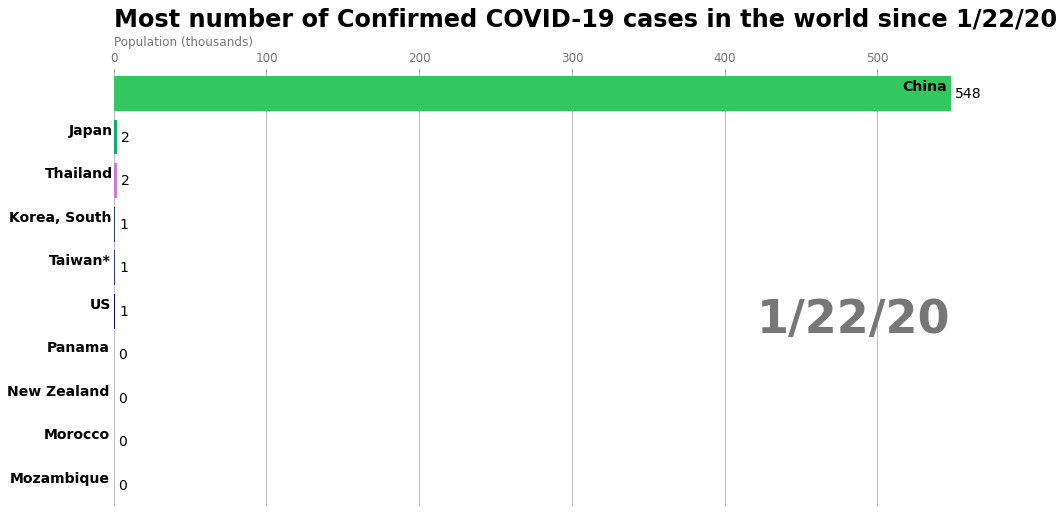

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
interval = 400  # ms pause btwn frames
animator = animation.FuncAnimation(fig, get_draw_fn(df_all), frames=adj_dates, interval=interval)
HTML(animator.to_jshtml())

## Format and save to csv for Flourish app
[Flourish](https://app.flourish.studio) provides a great platform for animating bar charts.  
Group by Country/Region and add image urls for better visualization

In [72]:
# Template data provided by Flourish. Contains some country->flag image url mappings we can use
template = pd.read_csv("./country_template.csv")  
country_images = template[["Country Name", "Image URL"]]
df_countries = df_conf_raw.groupby("Country/Region").sum().reset_index()
# fix a few known country names which don't match between the datasets
country_images["Country Name"][country_images["Country Name"] == 'Iran, Islamic Rep.'] = "Iran"
country_images["Country Name"][country_images["Country Name"] == 'USA'] = "US"
country_images["Country Name"][country_images["Country Name"] == 'UK'] = "United Kingdom"
country_images["Country Name"][country_images["Country Name"] == 'Korea, Rep.'] = "Korea, South"

df_countries["image_url"] = ""  # init with empty str
for country, url in country_images.values:
    _df = df_countries[df_countries["Country/Region"] == country]
    if _df.values.any():
        df_countries["image_url"][df_countries["Country/Region"] == country] = url

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
df_countries.to_csv("./world_covid19_mar28_2020.csv")

In [74]:
# print(country_images.values)